# House Sale Price Prediction

In [1]:
#We Begin by importing the necessary libraries.

import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor 
from collections import Counter
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.metrics import accuracy_score

%matplotlib inline

## Part 1 - Data Exploration

In [2]:
train = pd.read_csv("train.csv", low_memory=False)
test = pd.read_csv("test.csv", low_memory=False)

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [3]:
df = train
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Part 1.5 - Initial Impressions

#### Lets start by looking at Dates

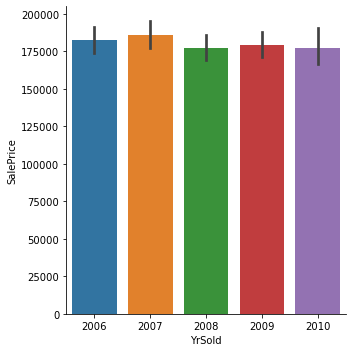

In [4]:
sns.catplot(data=train, kind="bar", x="YrSold", y="SalePrice")

The first thing to look for when you see Housing Prices during this period is how much the depression during 2008 affected prices. We can see that represented here because prices rise from 2006-2007, but fall from 2007-2008.

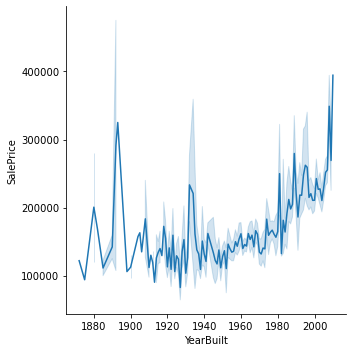

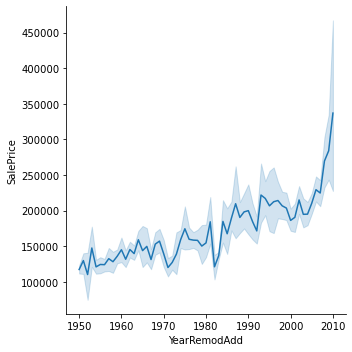

In [5]:
sns.relplot(data=train, kind="line", x="YearBuilt", y="SalePrice")
sns.relplot(data=train, kind="line", x="YearRemodAdd", y="SalePrice")

We see a few interesting trends here. Houses built during the late 1900s, as well as houses built during 1930s sell for more than those around their time. The remodel chart is much more standard and we can see that the houses that were remodeled later almost always sold for more.

#### Now lets look at Conditions of the properties

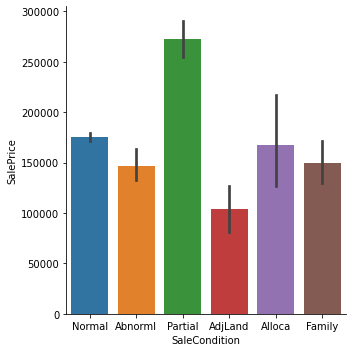

In [6]:
sns.catplot(data=train, kind="bar", x="SaleCondition", y="SalePrice")

The data continues to look normal here. Partial sales (which is listed as homes that are new) seem to sell for the most, while abnormal sales such as foreclosers sell for the lowest amount.

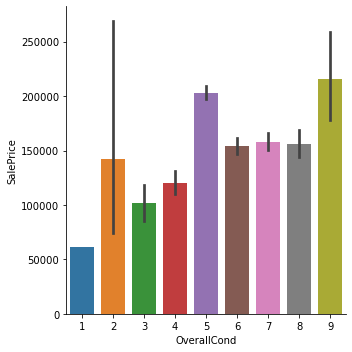

In [7]:
sns.catplot(data=train, kind="bar", x="OverallCond", y="SalePrice")

Here, we see a large amount of variation within the houses sold with a rating of 2 and 9. Lets explore further.

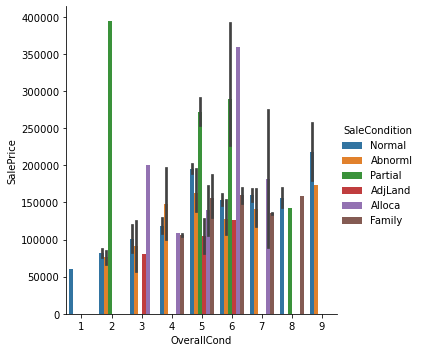

In [8]:
sns.catplot(data=train, kind="bar", x="OverallCond", y="SalePrice", hue="SaleCondition")

Now we can see that there was a house that was rated a 2, but was bought new for almost quadruple the prices of other properties that were rated at 2. The same seems to happen at 6, but its not as drastic as the property in 2. This could potential affect our models.

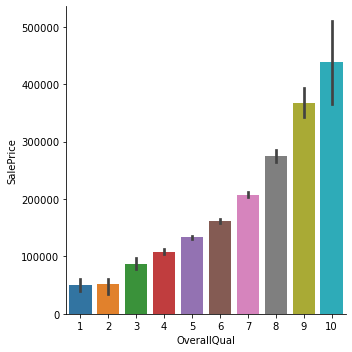

In [9]:
sns.catplot(data=train, kind="bar", x="OverallQual", y="SalePrice")

This is a great graph and could be a great feature in predicting the price of a house.

#### Now lets look at the types of properties/locations of properties that are being sold.

This should be the most important section because we would expect the type of house to be the largest factor in determining its price.

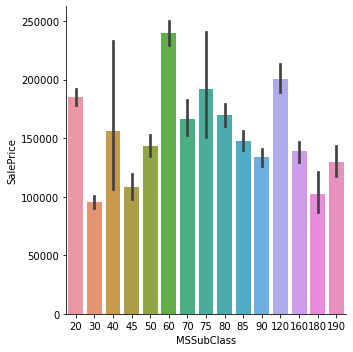

In [10]:
sns.catplot(data=train, kind="bar", x="MSSubClass", y="SalePrice")

We see that 60 is the most expensive type of dwelling that was sold. 60 identifies 2 story dwellings that were built in 1946 or later. 30 is the cheapest, and 30 is 1 story buildings that were built in 1945 or earlier.

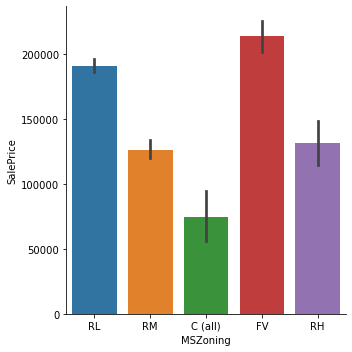

In [11]:
sns.catplot(data=train, kind="bar", x="MSZoning", y="SalePrice")

Out of the 3 R (Residential Zones), we can see that the low density residential zone (RL) was the one with the most demand. However, the area with the most expensive housing is actually the Floating Village-Residential which is a type of luxury housing. 

## Part 2 - Data Cleaning

In [12]:
df['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [13]:
df.loc[df["MSZoning"] == "A", "MSZoning"] = 0 
df.loc[df["MSZoning"] == "C (all)", "MSZoning"] = 1
df.loc[df["MSZoning"] == "FV", "MSZoning"] = 2 
df.loc[df["MSZoning"] == "I", "MSZoning"] = 3
df.loc[df["MSZoning"] == "RH", "MSZoning"] = 4
df.loc[df["MSZoning"] == "RL", "MSZoning"] = 5
df.loc[df["MSZoning"] == "RP", "MSZoning"] = 6
df.loc[df["MSZoning"] == "RM", "MSZoning"] = 7

In [14]:
df['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [15]:
df.loc[df["Street"] == "Pave", "Street"] = 0
df.loc[df["Street"] == "Grvl", "Street"] = 1

In [16]:
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [17]:
df.loc[df["Alley"] == "Pave", "Alley"] = 0
df.loc[df["Alley"] == "Grvl", "Alley"] = 1
df.loc[df["Alley"] == "NA", "Alley"] = 2

In [18]:
df['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [19]:
df.loc[df["LotShape"] == "Reg", "LotShape"] = 0
df.loc[df["LotShape"] == "IR1", "LotShape"] = 1
df.loc[df["LotShape"] == "IR2", "LotShape"] = 2
df.loc[df["LotShape"] == "IR3", "LotShape"] = 3

In [20]:
df['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [21]:
df.loc[df["LandContour"] == "Lvl", "LandContour"] = 0
df.loc[df["LandContour"] == "Bnk", "LandContour"] = 1
df.loc[df["LandContour"] == "HLS", "LandContour"] = 2
df.loc[df["LandContour"] == "Low", "LandContour"] = 3

In [22]:
df['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [23]:
df.loc[df["Utilities"] == "AllPub", "Utilities"] = 0
df.loc[df["Utilities"] == "NoSeWa", "Utilities"] = 1
df.loc[df["Utilities"] == "NoSewr", "Utilities"] = 2
df.loc[df["Utilities"] == "ELO", "Utilities"] = 3

In [24]:
df['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [25]:
df.loc[df["LotConfig"] == "Inside", "LotConfig"] = 0
df.loc[df["LotConfig"] == "Corner", "LotConfig"] = 1
df.loc[df["LotConfig"] == "CulDSac", "LotConfig"] = 2
df.loc[df["LotConfig"] == "FR2", "LotConfig"] = 3
df.loc[df["LotConfig"] == "FR3", "LotConfig"] = 4

In [26]:
df['LandSlope'].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [27]:
df.loc[df["LandSlope"] == "Gtl", "LandSlope"] = 0
df.loc[df["LandSlope"] == "Mod", "LandSlope"] = 1
df.loc[df["LandSlope"] == "Sev", "LandSlope"] = 2

In [28]:
df['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [29]:
df.loc[df["Neighborhood"] == "NAmes", "Neighborhood"] = 0
df.loc[df["Neighborhood"] == "CollgCr", "Neighborhood"] = 1
df.loc[df["Neighborhood"] == "OldTown", "Neighborhood"] = 2
df.loc[df["Neighborhood"] == "Edwards", "Neighborhood"] = 3
df.loc[df["Neighborhood"] == "Somerst", "Neighborhood"] = 4
df.loc[df["Neighborhood"] == "Gilbert", "Neighborhood"] = 5
df.loc[df["Neighborhood"] == "NridgHt", "Neighborhood"] = 6
df.loc[df["Neighborhood"] == "Sawyer", "Neighborhood"] = 7
df.loc[df["Neighborhood"] == "NWAmes", "Neighborhood"] = 8
df.loc[df["Neighborhood"] == "SawyerW", "Neighborhood"] = 9
df.loc[df["Neighborhood"] == "BrkSide", "Neighborhood"] = 10
df.loc[df["Neighborhood"] == "Crawfor", "Neighborhood"] = 11
df.loc[df["Neighborhood"] == "Mitchel", "Neighborhood"] = 12
df.loc[df["Neighborhood"] == "NoRidge", "Neighborhood"] = 13
df.loc[df["Neighborhood"] == "Timber", "Neighborhood"] = 14
df.loc[df["Neighborhood"] == "IDOTRR", "Neighborhood"] = 15
df.loc[df["Neighborhood"] == "ClearCr", "Neighborhood"] = 16
df.loc[df["Neighborhood"] == "StoneBr", "Neighborhood"] = 17
df.loc[df["Neighborhood"] == "SWISU", "Neighborhood"] = 18
df.loc[df["Neighborhood"] == "MeadowV", "Neighborhood"] = 19
df.loc[df["Neighborhood"] == "Blmngtn", "Neighborhood"] = 20
df.loc[df["Neighborhood"] == "BrDale", "Neighborhood"] = 21
df.loc[df["Neighborhood"] == "Veenker", "Neighborhood"] = 22
df.loc[df["Neighborhood"] == "NPkVill", "Neighborhood"] = 23
df.loc[df["Neighborhood"] == "Blueste", "Neighborhood"] = 24

In [30]:
df['Condition1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [31]:
df.loc[df["Condition1"] == "Norm", "Condition1"] = 0
df.loc[df["Condition1"] == "Feedr", "Condition1"] = 1
df.loc[df["Condition1"] == "Artery", "Condition1"] = 2
df.loc[df["Condition1"] == "RRAn", "Condition1"] = 3
df.loc[df["Condition1"] == "PosN", "Condition1"] = 4
df.loc[df["Condition1"] == "RRAe", "Condition1"] = 5
df.loc[df["Condition1"] == "PosA", "Condition1"] = 6
df.loc[df["Condition1"] == "RRNn", "Condition1"] = 7
df.loc[df["Condition1"] == "RRNe", "Condition1"] = 8

In [32]:
df['Condition2'].value_counts()

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

In [33]:
df.loc[df["Condition2"] == "Norm", "Condition2"] = 0
df.loc[df["Condition2"] == "Feedr", "Condition2"] = 1
df.loc[df["Condition2"] == "Artery", "Condition2"] = 2
df.loc[df["Condition2"] == "RRAn", "Condition2"] = 3
df.loc[df["Condition2"] == "PosN", "Condition2"] = 4
df.loc[df["Condition2"] == "RRAe", "Condition2"] = 5
df.loc[df["Condition2"] == "PosA", "Condition2"] = 6
df.loc[df["Condition2"] == "RRNn", "Condition2"] = 7
df.loc[df["Condition2"] == "RRNe", "Condition2"] = 8

In [34]:
df['BldgType'].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [35]:
df.loc[df["BldgType"] == "1Fam", "BldgType"] = 0
df.loc[df["BldgType"] == "TwnhsE", "BldgType"] = 1
df.loc[df["BldgType"] == "Duplex", "BldgType"] = 2
df.loc[df["BldgType"] == "Twnhs", "BldgType"] = 3
df.loc[df["BldgType"] == "2fmCon", "BldgType"] = 4

In [36]:
df['HouseStyle'].value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

In [37]:
df.loc[df["HouseStyle"] == "1Story", "HouseStyle"] = 0
df.loc[df["HouseStyle"] == "2Story", "HouseStyle"] = 1
df.loc[df["HouseStyle"] == "1.5Fin", "HouseStyle"] = 2
df.loc[df["HouseStyle"] == "SLvl", "HouseStyle"] = 3
df.loc[df["HouseStyle"] == "SFoyer", "HouseStyle"] = 4
df.loc[df["HouseStyle"] == "1.5Unf", "HouseStyle"] = 5
df.loc[df["HouseStyle"] == "2.5Unf", "HouseStyle"] = 6
df.loc[df["HouseStyle"] == "2.5Fin", "HouseStyle"] = 7

In [38]:
df['RoofStyle'].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [39]:
df.loc[df["RoofStyle"] == "Gable", "RoofStyle"] = 0
df.loc[df["RoofStyle"] == "Hip", "RoofStyle"] = 1
df.loc[df["RoofStyle"] == "Flat", "RoofStyle"] = 2
df.loc[df["RoofStyle"] == "Gambrel", "RoofStyle"] = 3
df.loc[df["RoofStyle"] == "Mansard", "RoofStyle"] = 4
df.loc[df["RoofStyle"] == "Shed", "RoofStyle"] = 5

In [40]:
df['RoofMatl'].value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64

In [41]:
df.loc[df["RoofMatl"] == "CompShg", "RoofMatl"] = 0
df.loc[df["RoofMatl"] == "Tar&Grv", "RoofMatl"] = 1
df.loc[df["RoofMatl"] == "WdShngl", "RoofMatl"] = 2
df.loc[df["RoofMatl"] == "WdShake", "RoofMatl"] = 3
df.loc[df["RoofMatl"] == "Metal", "RoofMatl"] = 4
df.loc[df["RoofMatl"] == "Membran", "RoofMatl"] = 5
df.loc[df["RoofMatl"] == "Roll", "RoofMatl"] = 6
df.loc[df["RoofMatl"] == "ClyTile", "RoofMatl"] = 7

In [42]:
df['Exterior1st'].value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64

In [43]:
df.loc[df["Exterior1st"] == "VinylSd", "Exterior1st"] = 0
df.loc[df["Exterior1st"] == "HdBoard", "Exterior1st"] = 1
df.loc[df["Exterior1st"] == "MetalSd", "Exterior1st"] = 2
df.loc[df["Exterior1st"] == "Wd Sdng", "Exterior1st"] = 3
df.loc[df["Exterior1st"] == "Plywood", "Exterior1st"] = 4
df.loc[df["Exterior1st"] == "CemntBd", "Exterior1st"] = 5
df.loc[df["Exterior1st"] == "BrkFace", "Exterior1st"] = 6
df.loc[df["Exterior1st"] == "WdShing", "Exterior1st"] = 7
df.loc[df["Exterior1st"] == "Stucco", "Exterior1st"] = 8
df.loc[df["Exterior1st"] == "AsbShng", "Exterior1st"] = 9
df.loc[df["Exterior1st"] == "BrkComm", "Exterior1st"] = 10
df.loc[df["Exterior1st"] == "Stone", "Exterior1st"] = 11
df.loc[df["Exterior1st"] == "AsphShn", "Exterior1st"] = 12
df.loc[df["Exterior1st"] == "ImStucc", "Exterior1st"] = 13
df.loc[df["Exterior1st"] == "CBlock", "Exterior1st"] = 14

df.loc[df["Exterior2nd"] == "VinylSd", "Exterior2nd"] = 0
df.loc[df["Exterior2nd"] == "HdBoard", "Exterior2nd"] = 1
df.loc[df["Exterior2nd"] == "MetalSd", "Exterior2nd"] = 2
df.loc[df["Exterior2nd"] == "Wd Sdng", "Exterior2nd"] = 3
df.loc[df["Exterior2nd"] == "Plywood", "Exterior2nd"] = 4
df.loc[df["Exterior2nd"] == "CemntBd", "Exterior2nd"] = 5
df.loc[df["Exterior2nd"] == "BrkFace", "Exterior2nd"] = 6
df.loc[df["Exterior2nd"] == "WdShing", "Exterior2nd"] = 7
df.loc[df["Exterior2nd"] == "Stucco", "Exterior2nd"] = 8
df.loc[df["Exterior2nd"] == "AsbShng", "Exterior2nd"] = 9
df.loc[df["Exterior2nd"] == "BrkComm", "Exterior2nd"] = 10
df.loc[df["Exterior2nd"] == "Stone", "Exterior2nd"] = 11
df.loc[df["Exterior2nd"] == "AsphShn", "Exterior2nd"] = 12
df.loc[df["Exterior2nd"] == "ImStucc", "Exterior2nd"] = 13
df.loc[df["Exterior2nd"] == "CBlock", "Exterior2nd"] = 14

In [44]:
df['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [45]:
df.loc[df["MasVnrType"] == "None", "MasVnrType"] = 0
df.loc[df["MasVnrType"] == "BrkFace", "MasVnrType"] = 1
df.loc[df["MasVnrType"] == "Stone", "MasVnrType"] = 2
df.loc[df["MasVnrType"] == "BrkCmn", "MasVnrType"] = 3
df.loc[df["MasVnrType"] == "CBlock", "MasVnrType"] = 4

In [46]:
df['ExterQual'].value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [47]:
df['ExterCond'].value_counts()

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [48]:
df.loc[df["ExterQual"] == "TA", "ExterQual"] = 0
df.loc[df["ExterQual"] == "Gd", "ExterQual"] = 1
df.loc[df["ExterQual"] == "Fa", "ExterQual"] = 2
df.loc[df["ExterQual"] == "Ex", "ExterQual"] = 3
df.loc[df["ExterQual"] == "Po", "ExterQual"] = 4

df.loc[df["ExterCond"] == "TA", "ExterCond"] = 0
df.loc[df["ExterCond"] == "Gd", "ExterCond"] = 1
df.loc[df["ExterCond"] == "Fa", "ExterCond"] = 2
df.loc[df["ExterCond"] == "Ex", "ExterCond"] = 3
df.loc[df["ExterCond"] == "Po", "ExterCond"] = 4

In [49]:
df['Foundation'].value_counts()

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

In [50]:
df.loc[df["Foundation"] == "PConc", "Foundation"] = 0
df.loc[df["Foundation"] == "CBlock", "Foundation"] = 1
df.loc[df["Foundation"] == "BrkTil", "Foundation"] = 2
df.loc[df["Foundation"] == "Slab", "Foundation"] = 3
df.loc[df["Foundation"] == "Stone", "Foundation"] = 4
df.loc[df["Foundation"] == "Wood", "Foundation"] = 5

In [51]:
df['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [52]:
df['BsmtCond'].value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [53]:
df.loc[df["BsmtQual"] == "Ex", "BsmtQual"] = 0
df.loc[df["BsmtQual"] == "Gd", "BsmtQual"] = 1
df.loc[df["BsmtQual"] == "TA", "BsmtQual"] = 2
df.loc[df["BsmtQual"] == "Fa", "BsmtQual"] = 3
df.loc[df["BsmtQual"] == "Po", "BsmtQual"] = 4
df.loc[df["BsmtQual"] == "NA", "BsmtQual"] = 5

df.loc[df["BsmtCond"] == "Ex", "BsmtCond"] = 0
df.loc[df["BsmtCond"] == "Gd", "BsmtCond"] = 1
df.loc[df["BsmtCond"] == "TA", "BsmtCond"] = 2
df.loc[df["BsmtCond"] == "Fa", "BsmtCond"] = 3
df.loc[df["BsmtCond"] == "Po", "BsmtCond"] = 4
df.loc[df["BsmtCond"] == "NA", "BsmtCond"] = 5

In [54]:
df['BsmtExposure'].value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [55]:
df.loc[df["BsmtExposure"] == "No", "BsmtExposure"] = 0
df.loc[df["BsmtExposure"] == "Av", "BsmtExposure"] = 1
df.loc[df["BsmtExposure"] == "Gd", "BsmtExposure"] = 2
df.loc[df["BsmtExposure"] == "Mn", "BsmtExposure"] = 3
df.loc[df["BsmtExposure"] == "NA", "BsmtExposure"] = 4

In [56]:
df['BsmtFinType1'].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [57]:
df.loc[df["BsmtFinType1"] == "Unf", "BsmtFinType1"] = 0
df.loc[df["BsmtFinType1"] == "GLQ", "BsmtFinType1"] = 1
df.loc[df["BsmtFinType1"] == "ALQ", "BsmtFinType1"] = 2
df.loc[df["BsmtFinType1"] == "BLQ", "BsmtFinType1"] = 3
df.loc[df["BsmtFinType1"] == "Rec", "BsmtFinType1"] = 4
df.loc[df["BsmtFinType1"] == "LwQ", "BsmtFinType1"] = 5

df.loc[df["BsmtFinType2"] == "Unf", "BsmtFinType2"] = 0
df.loc[df["BsmtFinType2"] == "GLQ", "BsmtFinType2"] = 1
df.loc[df["BsmtFinType2"] == "ALQ", "BsmtFinType2"] = 2
df.loc[df["BsmtFinType2"] == "BLQ", "BsmtFinType2"] = 3
df.loc[df["BsmtFinType2"] == "Rec", "BsmtFinType2"] = 4
df.loc[df["BsmtFinType2"] == "LwQ", "BsmtFinType2"] = 5

In [58]:
df['Heating'].value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [59]:
df.loc[df["Heating"] == "GasA", "Heating"] = 0
df.loc[df["Heating"] == "GasW", "Heating"] = 1
df.loc[df["Heating"] == "Grav", "Heating"] = 2
df.loc[df["Heating"] == "Wall", "Heating"] = 3
df.loc[df["Heating"] == "OthW", "Heating"] = 4
df.loc[df["Heating"] == "Floor", "Heating"] = 5

In [60]:
df['HeatingQC'].value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

In [61]:
df.loc[df["HeatingQC"] == "Ex", "HeatingQC"] = 0
df.loc[df["HeatingQC"] == "TA", "HeatingQC"] = 1
df.loc[df["HeatingQC"] == "Gd", "HeatingQC"] = 2
df.loc[df["HeatingQC"] == "Fa", "HeatingQC"] = 3
df.loc[df["HeatingQC"] == "Po", "HeatingQC"] = 4

In [62]:
df['CentralAir'].value_counts()

Y    1365
N      95
Name: CentralAir, dtype: int64

In [63]:
df.loc[df["CentralAir"] == "Y", "CentralAir"] = 0
df.loc[df["CentralAir"] == "N", "CentralAir"] = 1

In [64]:
df['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [65]:
df.loc[df["Electrical"] == "SBrkr", "Electrical"] = 0
df.loc[df["Electrical"] == "FuseA", "Electrical"] = 1
df.loc[df["Electrical"] == "FuseF", "Electrical"] = 2
df.loc[df["Electrical"] == "FuseP", "Electrical"] = 3
df.loc[df["Electrical"] == "Mix", "Electrical"] = 4

In [66]:
df['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

In [67]:
df.loc[df["KitchenQual"] == "TA", "KitchenQual"] = 0
df.loc[df["KitchenQual"] == "Gd", "KitchenQual"] = 1
df.loc[df["KitchenQual"] == "Ex", "KitchenQual"] = 2
df.loc[df["KitchenQual"] == "Fa", "KitchenQual"] = 3
df.loc[df["KitchenQual"] == "Po", "KitchenQual"] = 4

In [68]:
df['Functional'].value_counts()

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [69]:
df.loc[df["Functional"] == "Typ", "Functional"] = 0
df.loc[df["Functional"] == "Min2", "Functional"] = 1
df.loc[df["Functional"] == "Min1", "Functional"] = 2
df.loc[df["Functional"] == "Mod", "Functional"] = 3
df.loc[df["Functional"] == "Maj1", "Functional"] = 4
df.loc[df["Functional"] == "Maj2", "Functional"] = 5
df.loc[df["Functional"] == "Sev", "Functional"] = 6

In [70]:
df['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [71]:
df.loc[df["FireplaceQu"] == "Gd", "FireplaceQu"] = 0
df.loc[df["FireplaceQu"] == "TA", "FireplaceQu"] = 1
df.loc[df["FireplaceQu"] == "Fa", "FireplaceQu"] = 2
df.loc[df["FireplaceQu"] == "Ex", "FireplaceQu"] = 3
df.loc[df["FireplaceQu"] == "Po", "FireplaceQu"] = 4
df.loc[df["FireplaceQu"] == "NA", "FireplaceQu"] = 5

In [72]:
df['GarageType'].value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [73]:
df.loc[df["GarageType"] == "Attchd", "GarageType"] = 0
df.loc[df["GarageType"] == "Detchd", "GarageType"] = 1
df.loc[df["GarageType"] == "BuiltIn", "GarageType"] = 2
df.loc[df["GarageType"] == "Basment", "GarageType"] = 3
df.loc[df["GarageType"] == "CarPort", "GarageType"] = 4
df.loc[df["GarageType"] == "2Types", "GarageType"] = 5
df.loc[df["GarageType"] == "NA", "GarageType"] = 6

In [74]:
df['GarageFinish'].value_counts()

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [75]:
df.loc[df["GarageFinish"] == "Unf", "GarageFinish"] = 0
df.loc[df["GarageFinish"] == "RFn", "GarageFinish"] = 1
df.loc[df["GarageFinish"] == "Fin", "GarageFinish"] = 2
df.loc[df["GarageFinish"] == "NA", "GarageFinish"] = 3

In [76]:
df['GarageQual'].value_counts()

TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

In [77]:
df.loc[df["GarageQual"] == "TA", "GarageQual"] = 0
df.loc[df["GarageQual"] == "Fa", "GarageQual"] = 1
df.loc[df["GarageQual"] == "Gd", "GarageQual"] = 2
df.loc[df["GarageQual"] == "Ex", "GarageQual"] = 3
df.loc[df["GarageQual"] == "Po", "GarageQual"] = 4
df.loc[df["GarageQual"] == "NA", "GarageQual"] = 5

df.loc[df["GarageCond"] == "TA", "GarageCond"] = 0
df.loc[df["GarageCond"] == "Fa", "GarageCond"] = 1
df.loc[df["GarageCond"] == "Gd", "GarageCond"] = 2
df.loc[df["GarageCond"] == "Ex", "GarageCond"] = 3
df.loc[df["GarageCond"] == "Po", "GarageCond"] = 4
df.loc[df["GarageCond"] == "NA", "GarageCond"] = 5

In [78]:
df['PavedDrive'].value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [79]:
df.loc[df["PavedDrive"] == "Y", "PavedDrive"] = 0
df.loc[df["PavedDrive"] == "N", "PavedDrive"] = 1
df.loc[df["PavedDrive"] == "P", "PavedDrive"] = 2

In [80]:
df['PoolQC'].value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [81]:
df.loc[df["PoolQC"] == "Gd", "PoolQC"] = 0
df.loc[df["PoolQC"] == "Ex", "PoolQC"] = 1
df.loc[df["PoolQC"] == "Fa", "PoolQC"] = 2
df.loc[df["PoolQC"] == "NA", "PoolQC"] = 3

In [82]:
df['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [83]:
df.loc[df["Fence"] == "MnPrv", "Fence"] = 0
df.loc[df["Fence"] == "GdPrv", "Fence"] = 1
df.loc[df["Fence"] == "GdWo", "Fence"] = 2
df.loc[df["Fence"] == "MnWw", "Fence"] = 3
df.loc[df["Fence"] == "NA", "Fence"] = 4

In [84]:
df['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [85]:
df.loc[df["MiscFeature"] == "Elev", "MiscFeature"] = 0
df.loc[df["MiscFeature"] == "Gar2", "MiscFeature"] = 1
df.loc[df["MiscFeature"] == "Othr", "MiscFeature"] = 2
df.loc[df["MiscFeature"] == "Shed", "MiscFeature"] = 3
df.loc[df["MiscFeature"] == "TenC", "MiscFeature"] = 4
df.loc[df["MiscFeature"] == "NA", "MiscFeature"] = 5

In [86]:
df['SaleType'].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [87]:
df.loc[df["SaleType"] == "WD", "SaleType"] = 0
df.loc[df["SaleType"] == "New", "SaleType"] = 1
df.loc[df["SaleType"] == "COD", "SaleType"] = 2
df.loc[df["SaleType"] == "ConLD", "SaleType"] = 3
df.loc[df["SaleType"] == "ConLI", "SaleType"] = 4
df.loc[df["SaleType"] == "ConLw", "SaleType"] = 5
df.loc[df["SaleType"] == "CWD", "SaleType"] = 6
df.loc[df["SaleType"] == "Oth", "SaleType"] = 7
df.loc[df["SaleType"] == "Con", "SaleType"] = 8
df.loc[df["SaleType"] == "VWD", "SaleType"] = 9

In [88]:
df['SaleCondition'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [98]:
df.loc[df["SaleCondition"] == "Normal", "SaleCondition"] = 0
df.loc[df["SaleCondition"] == "Partial", "SaleCondition"] = 1
df.loc[df["SaleCondition"] == "Abnorml", "SaleCondition"] = 2
df.loc[df["SaleCondition"] == "Family", "SaleCondition"] = 3
df.loc[df["SaleCondition"] == "Alloca", "SaleCondition"] = 4
df.loc[df["SaleCondition"] == "AdjLand", "SaleCondition"] = 5

In [90]:
df['LotFrontage'].value_counts()

60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: LotFrontage, Length: 110, dtype: int64

In [91]:
df.loc[df["LotFrontage"] == "NA", "LotFrontage"] = 0

## Part 3 - Training Models

In [186]:
df.isnull().sum().transpose()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [226]:
x_columns = ["MSSubClass", "MSZoning", "SaleCondition", "YrSold", "LotArea", "SaleType", "Functional", 
             "LotArea", "Neighborhood", "Condition1", "BldgType", "HouseStyle", "ExterCond", "Street",
             "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "Exterior1st", "ExterQual",
             "Foundation", "CentralAir", "1stFlrSF", "2ndFlrSF", "GrLivArea", "FullBath", "KitchenQual", 
             "Fireplaces", "GarageArea", "PoolArea", "MoSold", "LotConfig"]
y = df["SalePrice"]
X = df[x_columns]
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.85, random_state = 1)

In [227]:
reg = LinearRegression() 
reg.fit(X_train, y_train)
print(reg.score(X_test, y_test))

0.854991926514846


In [228]:
#We run a boosting model.

gb = GradientBoostingRegressor() 
gb.fit(X_train, y_train) 
print(gb.score(X_test, y_test))

0.9125101478699436


In [229]:
forest_reg = RandomForestRegressor(random_state=1) 
forest_reg.fit(X_train, y_train) 

print(forest_reg.score(X_test, y_test))

0.9155915418863367


No handles with labels found to put in legend.


OverallQual      5.691456e-01
GrLivArea        1.224363e-01
1stFlrSF         6.239132e-02
GarageArea       4.385880e-02
2ndFlrSF         3.968730e-02
YearBuilt        2.487346e-02
LotArea          1.791957e-02
YearRemodAdd     1.740258e-02
LotArea          1.661379e-02
Neighborhood     1.549757e-02
FullBath         8.028194e-03
MoSold           7.671510e-03
ExterQual        5.646470e-03
OverallCond      5.455349e-03
KitchenQual      5.356456e-03
Fireplaces       5.321779e-03
Exterior1st      4.548464e-03
YrSold           3.715979e-03
MSZoning         3.562922e-03
MSSubClass       2.870381e-03
SaleType         2.700794e-03
CentralAir       2.338455e-03
LotConfig        1.960338e-03
Foundation       1.959631e-03
SaleCondition    1.937282e-03
Functional       1.781634e-03
PoolArea         1.561198e-03
Condition1       1.092121e-03
BldgType         9.967978e-04
HouseStyle       9.612304e-04
ExterCond        7.058336e-04
Street           8.350991e-07
dtype: float64


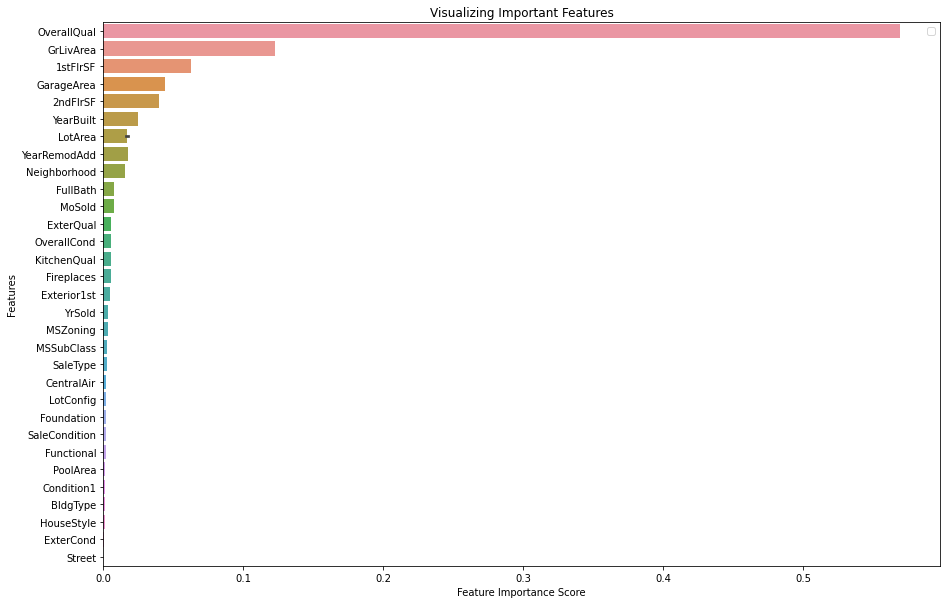

In [230]:
#We take our best model and look at the factors that were the most important in determining the Airbnb prices.

feature_imp = pd.Series(forest_reg.feature_importances_,index=x_columns).sort_values(ascending=False)
print(feature_imp)

%matplotlib inline
# Creating a bar plot
plt.figure(figsize=(15,10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()